# Top3 Flop3 Machine Learning Statistical Arbitrage Strategy

The strategy is inpired by the article "Statistical Arbitrage in Cryptocurrency Markets" by Fischer, Krauss, and Deinert who investigate the potential for statistical arbitrage in the rapidly growing and highly volatile cryptocurrency markets. The authors propose an algorithmic trading strategy that seeks to exploit the mean-reverting behavior of cryptocurrency prices.

**Abstract**

Machine learning research has gained momentum—also in finance. Consequently, initial machine-learning-based statistical arbitrage strategies have emerged in the U.S. equities markets in the academic literature, see e.g., Takeuchi and Lee (2013); Moritz and Zimmermann (2014); Krauss et al. (2017). With our paper, we pose the question how such a statistical arbitrage approach would fare in the cryptocurrency space on minute-binned data. Specifically, we train a random forest on lagged returns of 40 cryptocurrency coins, with the objective to predict whether a coin outperforms the cross-sectional median of all 40 coins over the subsequent 120 min. We buy the coins with the top-3 predictions and short-sell the coins with the flop-3 predictions, only to reverse the positions after 120 min. During the out-of-sample period of our backtest, ranging from 18 June 2018 to 17 September 2018, and after more than 100,000 trades, we find statistically and economically significant returns of 7.1 bps per day, after transaction costs of 15 bps per half-turn. While this finding poses a challenge to the semi-strong from of market efficiency, we critically discuss it in light of limits to arbitrage, focusing on total volume constraints of the presented intraday-strategy.

In [1]:
import os
import numpy as np
import pandas as pd
import pickle

from pykalman import KalmanFilter
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from dataprovider import CryptoMinuteDataProvider
import feature_generator as fg
from kpi_backtest import kpi_backtest

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from datetime import datetime

date_format = "%d %b %Y %H:%M:%S"
start_date_str = "01 May 2022 00:00:00"
end_date_str = "01 May 2023 00:00:00"

start_date = datetime.strptime(start_date_str, date_format)
end_date = datetime.strptime(end_date_str, date_format)

difference = end_date - start_date
minutes_difference = difference.total_seconds() / 60

print(f"The number of minutes between {start_date_str} and {end_date_str} is {minutes_difference:.0f} minutes.")


The number of minutes between 01 May 2022 00:00:00 and 01 May 2023 00:00:00 is 525600 minutes.


In [2]:
1000*1200

1200000

## 1. Importing and Preparing Data

In [3]:
data_path = 'C:\\Users\\ReinisFals\\OneDrive - Peero, SIA\\Desktop\\stat_arb_research\\stat_arb_research\\data\\A_MERGEABLE\\'

In [4]:
np.random.seed(20)

# Some options for configuration
FORECAST_HORIZON = 120            # for the targets in minutes
TRAIN_TEST_SPLIT = 2/3

In [5]:
dataframes = {}

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    if os.path.isdir(folder_path):
        parquet_files = [file for file in os.listdir(folder_path) if file.endswith('combined.parquet')]
        for file in parquet_files:
            file_path = os.path.join(folder_path, file)
            df = pd.read_parquet(file_path)
            dataframes[file[:-8]] = df

In [6]:
dataframes.keys()

dict_keys(['AAVE_combined', 'ADA_combined', 'ALGO_combined', 'APE_combined', 'APT_combined', 'ARB_combined', 'ATOM_combined', 'AVAX_combined', 'AXS_combined', 'BCH_combined', 'BNB_combined', 'BTC_combined', 'CAKE_combined', 'CRV_combined', 'DOGE_combined', 'DOT_combined', 'DYDX_combined', 'EGLD_combined', 'EOS_combined', 'ETC_combined', 'ETH_combined', 'FIL_combined', 'FLOW_combined', 'FTM_combined', 'GALA_combined', 'GRT_combined', 'HBAR_combined', 'ICP_combined', 'IMX_combined', 'INJ_combined', 'LDO_combined', 'LINK_combined', 'LTC_combined', 'MAGIC_combined', 'MANA_combined', 'MATIC_combined', 'MKR_combined', 'NEAR_combined', 'NEO_combined', 'OP_combined', 'QNT_combined', 'RNDR_combined', 'RPL_combined', 'SAND_combined', 'SHIB_combined', 'SOL_combined', 'STX_combined', 'THETA_combined', 'TRX_combined', 'UNI_combined', 'VET_combined', 'XEC_combined', 'XLM_combined', 'XMR_combined', 'XRP_combined', 'XTZ_combined'])

In [7]:
dataframes['AAVE_combined'].head()

,open,high,low,close,volume,quote_asset_volume,count,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
open_time,,,,,,,,,
2020-10-15 03:00:00,51.430,59.000,50.666,55.607,1369.481,75607.779013,361,898.434,50012.700480
2020-10-15 03:01:00,55.603,55.623,52.000,52.845,1120.278,59696.689968,178,658.949,35330.288555
2020-10-15 03:02:00,52.845,52.846,51.283,51.999,466.672,24288.122840,94,185.675,9659.760008
2020-10-15 03:03:00,51.999,52.000,50.665,51.736,205.109,10594.203061,68,78.099,4043.744534
2020-10-15 03:04:00,51.742,51.776,51.500,51.632,310.324,16011.251406,44,174.396,9004.233218


In [8]:
provider = CryptoMinuteDataProvider(dataframes)
raw_data = provider.get_full_raw_data()

[INFO] Rebuilding raw data from Parquet files
[INFO] Processing AAVE_combined
[INFO] Processing ADA_combined
[INFO] Processing ALGO_combined
[INFO] Processing APE_combined
[INFO] Processing APT_combined
[INFO] Processing ARB_combined
[INFO] Processing ATOM_combined
[INFO] Processing AVAX_combined
[INFO] Processing AXS_combined
[INFO] Processing BCH_combined
[INFO] Processing BNB_combined
[INFO] Processing BTC_combined
[INFO] Processing CAKE_combined
[INFO] Processing CRV_combined
[INFO] Processing DOGE_combined
[INFO] Processing DOT_combined
[INFO] Processing DYDX_combined
[INFO] Processing EGLD_combined
[INFO] Processing EOS_combined
[INFO] Processing ETC_combined
[INFO] Processing ETH_combined
[INFO] Processing FIL_combined
[INFO] Processing FLOW_combined
[INFO] Processing FTM_combined
[INFO] Processing GALA_combined
[INFO] Processing GRT_combined
[INFO] Processing HBAR_combined
[INFO] Processing ICP_combined
[INFO] Processing IMX_combined
[INFO] Processing INJ_combined
[INFO] Proces

In [9]:
raw_data.rename(columns={'taker_buy_base_asset_volume': 'volume_to', 'taker_buy_quote_asset_volume': 'volume_from'}, inplace=True)
raw_data

open       high        low      close  \
Date       Coin                                                        
2022-05-01 AAVE_combined  142.30000  142.50000  142.10000  142.30000   
           ADA_combined     0.75550    0.75620    0.75420    0.75560   
           ALGO_combined    0.56720    0.56840    0.56700    0.56770   
           APE_combined    19.99000   20.00000   19.75070   19.94640   
           APT_combined         NaN        NaN        NaN        NaN   
...                             ...        ...        ...        ...   
2023-05-01 XEC_combined     0.00003    0.00003    0.00003    0.00003   
           XLM_combined     0.09440    0.09450    0.09430    0.09450   
           XMR_combined   155.50000  155.50000  154.60000  155.10000   
           XRP_combined     0.47050    0.47130    0.47040    0.47080   
           XTZ_combined     1.00000    1.00100    0.99900    0.99900   

                            volume_to   volume_from  
Date       Coin                                      
2022-05-01 AAVE_combined      114.258  1.625806e+04  
           ADA_combined    125061.000  9.446724e+04  
           ALGO_combined    41247.000  2.341402e+04  
           APE_combined     53074.770  1.054616e+06  
           APT_combined         0.000  0.000000e+00  
...                               ...           ...  
2023-05-01 XEC_combined   4717946.000  1.400329e+02  
           XLM_combined     59221.000  5.595528e+03  
           XMR_combined       192.499  2.987542e+04  
           XRP_combined    614773.000  2.895395e+05  
           XTZ_combined       220.200  2.202200e+02  

[29433656 rows x 6 columns]

## 2. Features & Targets

**Features - Multiperiod Returns**
<br>
<br>
Loosely following the logic of [Takeuchi and Lee (2013)](https://cs229.stanford.edu/proj2013/TakeuchiLee-ApplyingDeepLearningToEnhanceMomentumTradingStrategiesInStocks.pdf), each feature sequence (input) is generated in the following way: Let $ P^c = (P^c_t)_{t \in T} $ denote the price process of coin $c$ with $c \in$ {1,...,10}, and $R^c_{t,t-m} $ the simple return for a coin c over the last $m$ periods, i.e.,
$$ R^c_{t,t-m} = \frac{P^c_t}{P^c_{t-m}} - 1. $$

where the periods are in minutes. Each feature sequence then consists of the set $ R^c_{t,t-m} $ with $ m \in $ {{20,40,60,80,100,120} $ \cup $ {240,...,1320,1440}}. Hence, the model first puts emphasis on the returns of the last 120 min and then switches to a less granular resolution to focus on the returns of the last $ k \cdot 120 $ ,with $ k \in $ {2,...,12}, points in time. With this approach, I follow the logic of [Takeuchi and Lee (2013)](https://cs229.stanford.edu/proj2013/TakeuchiLee-ApplyingDeepLearningToEnhanceMomentumTradingStrategiesInStocks.pdf) and transfer it to minute-binned data with the aim of forecasting the return of the next two hours or 120 min, while using information of the returns of the last 24 h.

**Targets - Binary Classification**
<br>
<br>
As in [Krauss et al. (2017)](https://www.sciencedirect.com/science/article/abs/pii/S0377221716308657), a binary response variable $Y^c_{t+121,t+1} \in $ {0,1} is introduced. All target
values of the cross-section are classified as class “1” if the return over the 120 min after the predict time $t$ (including a one minute gap), i.e., $R^c_{t+121,t+1}$, is greater than the cross-sectional median of all 10 coins, and as class “0” otherwise. Therefore, instead of predicting the actual value of the future 120 min returns, the probability $ \hat{p}^c_{t+121,t+1} $ of a coin $c$ outperforming the cross-sectional median is predicted.
This approach is promising, as **classification problems have found to work better than regression problems in the context of financial market predictions** (see [Enke and Thawornwong (2005)](https://www.sciencedirect.com/science/article/abs/pii/S0957417405001156) and [Leung et al.(2000)](https://www.sciencedirect.com/science/article/abs/pii/S0169207099000485)).

### 2.1 Defining Features & Targets

In [10]:
feature_calculations = []
# multi-period returns
for period in np.append(np.arange(1, 21), [120 * x for x in np.arange(1, 13)]):
    feature_calculations.append((fg.calculate_discrete_multiperiod_returns, {'period': period}))

### 2.2 Computing Features & Targets

In [11]:
features, targets = fg.compile_features_and_targets(raw_data, FORECAST_HORIZON, 
                                                    2, feature_calculations)

[INFO] Compiling features and targtes
[INFO] Building feature (<function calculate_discrete_multiperiod_returns at 0x00000204EE9AFAF0>, {'period': 1})
[INFO] Building feature (<function calculate_discrete_multiperiod_returns at 0x00000204EE9AFAF0>, {'period': 2})
[INFO] Building feature (<function calculate_discrete_multiperiod_returns at 0x00000204EE9AFAF0>, {'period': 3})
[INFO] Building feature (<function calculate_discrete_multiperiod_returns at 0x00000204EE9AFAF0>, {'period': 4})
[INFO] Building feature (<function calculate_discrete_multiperiod_returns at 0x00000204EE9AFAF0>, {'period': 5})
[INFO] Building feature (<function calculate_discrete_multiperiod_returns at 0x00000204EE9AFAF0>, {'period': 6})
[INFO] Building feature (<function calculate_discrete_multiperiod_returns at 0x00000204EE9AFAF0>, {'period': 7})
[INFO] Building feature (<function calculate_discrete_multiperiod_returns at 0x00000204EE9AFAF0>, {'period': 8})
[INFO] Building feature (<function calculate_discrete_mult

## 3. Train-Test Split

In [28]:
all_dates = raw_data.index.get_level_values('Date').drop_duplicates().values
idx_first_date_of_testing = int(len(all_dates)*TRAIN_TEST_SPLIT)
idx_first_date_of_training = idx_first_date_of_testing - FORECAST_HORIZON - 1
first_date_of_testing = all_dates[idx_first_date_of_testing]
last_date_of_training = all_dates[idx_first_date_of_training]

In [29]:
training_features = features.loc[features.index.get_level_values('Date') <= last_date_of_training]
training_targets = targets.loc[targets.index.get_level_values('Date') <= last_date_of_training]

In [30]:
test_features = features.loc[features.index.get_level_values('Date') >= first_date_of_testing]
test_targets = targets.loc[targets.index.get_level_values('Date') >= first_date_of_testing]

## 4. Model Development & Training

### 4.1 Random Forest

Following [Krauss et al. (2017)](https://www.sciencedirect.com/science/article/abs/pii/S0377221716308657), who find the random forest (RF) to yield the best trading performance in their empirical study for the S&P 500 constitutents, I opt for this model as the machine learning benchmark. Random forests [Breiman (1996, 2001)](https://link.springer.com/article/10.1007/BF00058655); [Ho (1995, 1998)](https://ieeexplore.ieee.org/abstract/document/598994) are ensemble learners consisting of many decorrelated decision trees which can be understood as their building blocks. During the learning phase, the decision trees are trained individually on random subsets of the training samples. Hereby, each tree is “grown” with the objective of separating the training samples as pure as possible with respect to their class (the target value “0” or “1”). At each split (node of the tree), the samples are divided into two buckets depending on whether or not the respective sample fulfills the learned split criterion, e.g., whether or not the value of the feature “return over the past 60 min” exceeds 3 percent. This process is repeated recursively until all buckets are pure or another stop criterion, e.g., max depth J of the tree, is reached. Once all trees are trained, the random forest model can be applied to make predictions for the unseen data. Hereby, each tree of the forest predicts the class of the new sample based on its learned split criterions—simply speaking, if the new sample is sorted into a “0” bucket, the tree predicts “0”, otherwise “1”. In the last step, the predictions of all B trees of the forest are averaged to compute the final prediction—a value between 0 and 1 which can be interpreted as the probability that the sample belongs to class “1”.

As random forest implementation, I use [Pedregosa et al. (2011)](https://www.jmlr.org/papers/volume12/pedregosa11a/pedregosa11a.pdf?ref=https:/) and largely follow [Fischer and Krauss (2018)](https://www.sciencedirect.com/science/article/abs/pii/S0377221717310652) and [Krauss et al. (2017)](https://www.sciencedirect.com/science/article/abs/pii/S0377221716308657) with respect to the parameters of random forest model. Specifically, I set the number of trees $B$ to 1000 and the maximum tree depth $J$ to 15. For the random feature selection, I follow the default value $ m = \sqrt{p} $ for classification, whereby $p$ denotes the number of features, see [Pedregosa et al. (2011)](https://www.jmlr.org/papers/volume12/pedregosa11a/pedregosa11a.pdf?ref=https:/).

In [65]:
model = RandomForestClassifier(n_estimators=1000, max_depth=15, n_jobs=-1, verbose=1)
model.fit(training_features, training_targets)

C:\Users\ReinisFals\AppData\Local\Temp\ipykernel_27568\1943568789.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(training_features, training_targets)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 20.2min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

In [66]:
# saving the model
save_path = r'C:\Users\ReinisFals\OneDrive - Peero, SIA\Desktop\Statistical_Arbitrage\binance_stat_arb\3 ML Pairs\models'
filename = 'rf2020.pkl'
file_path = os.path.join(save_path, filename)
with open(file_path, 'wb') as f:
    pickle.dump(model, f)

In [31]:
# openen the model
save_path = r'C:\Users\ReinisFals\OneDrive - Peero, SIA\Desktop\Statistical_Arbitrage\binance_stat_arb\3 ML Pairs\models'
filename = 'rf2020.pkl'
file_path = os.path.join(save_path, filename)
with open(file_path, 'rb') as f:
    model = pickle.load(f)

In [33]:
# to save upon memory, we predict coin by coin
coin_names = test_targets.index.get_level_values('Coin').drop_duplicates().values
predictions_rf = []
for a_coin in coin_names:
    print('[INFO] Predicting coin', a_coin)
    coin_test_features = test_features.xs(a_coin, level='Coin')
    a_pred = model.predict_proba(coin_test_features)
    a_pred = a_pred[:, -1]
    a_pred = pd.DataFrame(a_pred)
    a_pred.index = test_features.xs(a_coin, level='Coin', drop_level=False).index
    a_pred.columns = ['prediction']
    predictions_rf.append(a_pred)
predictions_rf = pd.concat(predictions_rf)
predictions_rf = predictions_rf.sort_index(0, level='Date')

[INFO] Predicting coin ADA-USDT


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    1.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


[INFO] Predicting coin BNB-USDT


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    1.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


[INFO] Predicting coin BTC-USDT


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    1.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


[INFO] Predicting coin DOGE-USDT


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    1.0s finished


[INFO] Predicting coin DOT-USDT


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    1.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


[INFO] Predicting coin ETH-USDT


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


[INFO] Predicting coin LTC-USDT


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


[INFO] Predicting coin MATIC-USDT


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    1.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


[INFO] Predicting coin SOL-USDT


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    1.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s


[INFO] Predicting coin XRP-USDT


[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    1.0s finished
C:\Users\ReinisFals\AppData\Local\Temp\ipykernel_18932\2425594118.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  predictions_rf = predictions_rf.sort_index(0, level='Date')


In [35]:
# Compute the predicted classes for the test set
predicted_classes_rf = (predictions_rf['prediction'] >= 0.5).astype(int)

# Extract the true classes from the test_targets
true_classes = test_targets.values

# Calculate the accuracy score
rf_accuracy = accuracy_score(true_classes, predicted_classes_rf)
print(f"Random Forest Model Accuracy: {rf_accuracy}")

Random Forest Model Accuracy: 0.5140181992337165


In [68]:
predictions_rf

prediction
Date                Coin                  
2020-10-17 00:01:00 ADA-USDT      0.489190
                    BNB-USDT      0.519937
                    BTC-USDT      0.547101
                    DOGE-USDT     0.531178
                    DOT-USDT      0.535131
...                                    ...
2020-11-15 00:00:00 ETH-USDT      0.577302
                    LTC-USDT      0.583029
                    MATIC-USDT    0.425148
                    SOL-USDT      0.508986
                    XRP-USDT      0.541929

[417600 rows x 1 columns]

In [69]:
# save the predictions_rf as csv
predictions_rf.to_csv(r'C:\Users\ReinisFals\OneDrive - Peero, SIA\Desktop\Statistical_Arbitrage\binance_stat_arb\3 ML Pairs\predictions\predictions_rf2020.csv')

### 4.2 K-Nearest Neighbors

In [18]:
model_knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
model_knn.fit(training_features, training_targets)

C:\Users\ReinisFals\AppData\Local\Temp\ipykernel_3036\3884701928.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  model_knn.fit(training_features, training_targets)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [19]:
# saving the model
save_path = r'C:\Users\ReinisFals\OneDrive - Peero, SIA\Desktop\Statistical_Arbitrage\binance_stat_arb\3 ML Pairs\models'
filename = 'knn2020.pkl'
file_path = os.path.join(save_path, filename)
with open(file_path, 'wb') as f:
    pickle.dump(model_knn, f)

In [13]:
# openen the model
save_path = r'C:\Users\ReinisFals\OneDrive - Peero, SIA\Desktop\Statistical_Arbitrage\binance_stat_arb\3 ML Pairs\models'
filename = 'knn2020.pkl'
file_path = os.path.join(save_path, filename)
with open(file_path, 'rb') as f:
    model_knn = pickle.load(f)

In [16]:
# to save upon memory, we predict coin by coin
coin_names = test_targets.index.get_level_values('Coin').drop_duplicates().values
predictions_knn = []
for a_coin in coin_names:
    print('[INFO] Predicting coin', a_coin)
    coin_test_features = test_features.xs(a_coin, level='Coin')
    a_pred = model_knn.predict_proba(coin_test_features)
    a_pred = a_pred[:, -1]
    a_pred = pd.DataFrame(a_pred)
    a_pred.index = test_features.xs(a_coin, level='Coin', drop_level=False).index
    a_pred.columns = ['prediction']
    predictions_knn.append(a_pred)
predictions_knn = pd.concat(predictions_knn)
predictions_knn = predictions_knn.sort_index(0, level='Date')

[INFO] Predicting coin ADA-USDT
[INFO] Predicting coin BNB-USDT
[INFO] Predicting coin BTC-USDT
[INFO] Predicting coin DOGE-USDT
[INFO] Predicting coin DOT-USDT
[INFO] Predicting coin ETH-USDT
[INFO] Predicting coin LTC-USDT
[INFO] Predicting coin MATIC-USDT
[INFO] Predicting coin SOL-USDT
[INFO] Predicting coin XRP-USDT


C:\Users\ReinisFals\AppData\Local\Temp\ipykernel_27568\549552041.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  predictions_knn = predictions_knn.sort_index(0, level='Date')


In [38]:
# Compute the predicted classes for the test set
predictions_knn = pd.read_csv(r'C:\Users\ReinisFals\OneDrive - Peero, SIA\Desktop\Statistical_Arbitrage\binance_stat_arb\3 ML Pairs\predictions\predictions_knn2020.csv', index_col=[0,1])
predicted_classes_knn = (predictions_knn['prediction'] >= 0.5).astype(int)

# Extract the true classes from the test_targets
true_classes = test_targets.values

# Calculate the accuracy score
knn_accuracy = accuracy_score(true_classes, predicted_classes_knn)
print(f"KNN Model Accuracy: {knn_accuracy}")

KNN Model Accuracy: 0.505205938697318


In [21]:
predictions_knn

prediction
Date                Coin                  
2020-10-17 00:01:00 ADA-USDT           1.0
                    BNB-USDT           1.0
                    BTC-USDT           0.6
                    DOGE-USDT          0.4
                    DOT-USDT           1.0
...                                    ...
2020-11-15 00:00:00 ETH-USDT           1.0
                    LTC-USDT           1.0
                    MATIC-USDT         0.2
                    SOL-USDT           0.0
                    XRP-USDT           0.0

[417600 rows x 1 columns]

In [19]:
# save the predictions_knn as csv
predictions_knn.to_csv(r'C:\Users\ReinisFals\OneDrive - Peero, SIA\Desktop\Statistical_Arbitrage\binance_stat_arb\3 ML Pairs\predictions\predictions_knn2020.csv')

### 4.3 Extreme Gradient Boosting

In [25]:
xgb_model = xgb.XGBClassifier(n_estimators=1000, max_depth=20, learning_rate=0.01, n_jobs=-1, verbosity=2)
xgb_model.fit(training_features, training_targets)

[18:45:09] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 26368 extra nodes, 0 pruned nodes, max_depth=20
[18:45:15] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 24522 extra nodes, 0 pruned nodes, max_depth=20
[18:45:20] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 23928 extra nodes, 0 pruned nodes, max_depth=20
[18:45:24] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 24254 extra nodes, 0 pruned nodes, max_depth=20
[18:45:29] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-075

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)

In [26]:
# saving the model
save_path = r'C:\Users\ReinisFals\OneDrive - Peero, SIA\Desktop\Statistical_Arbitrage\binance_stat_arb\3 ML Pairs\models'
filename = 'xgb2020.pkl'
file_path = os.path.join(save_path, filename)
with open(file_path, 'wb') as f:
    pickle.dump(xgb_model, f)

In [14]:
# openen the model
save_path = r'C:\Users\ReinisFals\OneDrive - Peero, SIA\Desktop\Statistical_Arbitrage\binance_stat_arb\3 ML Pairs\models'
filename = 'xgb2020.pkl'
file_path = os.path.join(save_path, filename)
with open(file_path, 'rb') as f:
    xgb_model = pickle.load(f)

In [26]:
# Predict coin by coin
predictions_xgb = []
for a_coin in coin_names:
    print('[INFO] Predicting coin', a_coin)
    coin_test_features = test_features.xs(a_coin, level='Coin')
    a_pred = xgb_model.predict_proba(coin_test_features)
    a_pred = a_pred[:, -1]
    a_pred = pd.DataFrame(a_pred)
    a_pred.index = test_features.xs(a_coin, level='Coin', drop_level=False).index
    a_pred.columns = ['prediction']
    predictions_xgb.append(a_pred)
predictions_xgb = pd.concat(predictions_xgb)
predictions_xgb = predictions_xgb.sort_index(0, level='Date')

[INFO] Predicting coin ADA-USDT
[INFO] Predicting coin BNB-USDT
[INFO] Predicting coin BTC-USDT
[INFO] Predicting coin DOGE-USDT
[INFO] Predicting coin DOT-USDT
[INFO] Predicting coin ETH-USDT
[INFO] Predicting coin LTC-USDT
[INFO] Predicting coin MATIC-USDT
[INFO] Predicting coin SOL-USDT
[INFO] Predicting coin XRP-USDT


C:\Users\ReinisFals\AppData\Local\Temp\ipykernel_27568\1595642174.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  predictions_xgb = predictions_xgb.sort_index(0, level='Date')


In [39]:
# Compute the predicted classes for the test set
predictions_xgb = pd.read_csv(r'C:\Users\ReinisFals\OneDrive - Peero, SIA\Desktop\Statistical_Arbitrage\binance_stat_arb\3 ML Pairs\predictions\predictions_xgb2020.csv', index_col=[0,1])
predicted_classes_xgb = (predictions_xgb['prediction'] >= 0.5).astype(int)

# Extract the true classes from the test_targets
true_classes = test_targets.values

# Calculate the accuracy score
xgb_accuracy = accuracy_score(true_classes, predicted_classes_xgb)
print(f"xgb Model Accuracy: {xgb_accuracy}")

xgb Model Accuracy: 0.5079142720306513


In [27]:
predictions_xgb

prediction
Date                Coin                  
2020-10-17 00:01:00 ADA-USDT      0.675392
                    BNB-USDT      0.656882
                    BTC-USDT      0.680745
                    DOGE-USDT     0.547388
                    DOT-USDT      0.673716
...                                    ...
2020-11-15 00:00:00 ETH-USDT      0.807619
                    LTC-USDT      0.810115
                    MATIC-USDT    0.275819
                    SOL-USDT      0.344648
                    XRP-USDT      0.627353

[417600 rows x 1 columns]

In [ ]:
# save the predictions_xgb as csv
predictions_xgb.to_csv(r'C:\Users\ReinisFals\OneDrive - Peero, SIA\Desktop\Statistical_Arbitrage\binance_stat_arb\3 ML Pairs\predictions\predictions_xgb2020.csv')

### 4.4 Light Gradient Boosting

In [43]:
model_lgb = lgb.LGBMClassifier(n_estimators=1000, max_depth=15, num_leaves=2**15, force_col_wise=True, verbose=1)
model_lgb.fit(training_features, training_targets)

c:\Users\ReinisFals\anaconda3\envs\stat_arb_env\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ReinisFals\anaconda3\envs\stat_arb_env\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Number of positive: 409209, number of negative: 409181
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 818390, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500017 -> initscore=0.000068
[LightGBM] [Info] Start training from score 0.000068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               force_col_wise=True, importance_type='split', learning_rate=0.1,
               max_depth=15, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=1000, n_jobs=-1,
               num_leaves=32768, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent='warn', subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbose=1)

In [44]:
# saving the model
save_path = r'C:\Users\ReinisFals\OneDrive - Peero, SIA\Desktop\Statistical_Arbitrage\binance_stat_arb\3 ML Pairs\models'
filename = 'lgb2020.pkl'
file_path = os.path.join(save_path, filename)
with open(file_path, 'wb') as f:
    pickle.dump(model_lgb, f)

In [ ]:
# openen the model
save_path = r'C:\Users\ReinisFals\OneDrive - Peero, SIA\Desktop\Statistical_Arbitrage\binance_stat_arb\3 ML Pairs\models'
filename = 'lgb2020.pkl'
file_path = os.path.join(save_path, filename)
with open(file_path, 'rb') as f:
    model_lgb = pickle.load(f)

In [45]:
# Predict coin by coin
predictions_lgb = []
for a_coin in coin_names:
    print('[INFO] Predicting coin', a_coin)
    coin_test_features = test_features.xs(a_coin, level='Coin')
    a_pred = model_lgb.predict_proba(coin_test_features)
    a_pred = a_pred[:, -1]
    a_pred = pd.DataFrame(a_pred)
    a_pred.index = test_features.xs(a_coin, level='Coin', drop_level=False).index
    a_pred.columns = ['prediction']
    predictions_lgb.append(a_pred)
predictions_lgb = pd.concat(predictions_lgb)
predictions_lgb = predictions_lgb.sort_index(0, level='Date')

[INFO] Predicting coin ADA-USDT
[INFO] Predicting coin BNB-USDT
[INFO] Predicting coin BTC-USDT
[INFO] Predicting coin DOGE-USDT
[INFO] Predicting coin DOT-USDT
[INFO] Predicting coin ETH-USDT
[INFO] Predicting coin LTC-USDT
[INFO] Predicting coin MATIC-USDT
[INFO] Predicting coin SOL-USDT
[INFO] Predicting coin XRP-USDT


C:\Users\ReinisFals\AppData\Local\Temp\ipykernel_18932\3483152256.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  predictions_lgb = predictions_lgb.sort_index(0, level='Date')


In [46]:
# Compute the predicted classes for the test set
predicted_classes_lgb = (predictions_lgb['prediction'] >= 0.5).astype(int)

# Extract the true classes from the test_targets
true_classes = test_targets.values

# Calculate the accuracy score
lgb_accuracy = accuracy_score(true_classes, predicted_classes_lgb)
print(f"lgb Model Accuracy: {lgb_accuracy}")

lgb Model Accuracy: 0.5058285440613027


In [47]:
# save the predictions_lgb as csv
predictions_lgb.to_csv(r'C:\Users\ReinisFals\OneDrive - Peero, SIA\Desktop\Statistical_Arbitrage\binance_stat_arb\3 ML Pairs\predictions\predictions_lgb2020.csv')

## 5. Backtesting

Once the three models are trained using the features and targets of the training set (Note: I train universal models, i.e., each of the three models is trained using the samples of all coins), the learned parameters are fixed and the two models are transferred to the **trading phase.** 
In this phase, only the features are used (which are limited to the information an investor would have known at the respective point in time) and out of sample predictions are made. Specifically, at the end of each minute $t$ of the trading period, each model forecasts the price development of all individual coins over the next two hours, i.e., the probability to outperform the cross-sectional median. I hence obtain two lists (one list per model) with 10 probabilities (one for each coin) which I sort in descending order. At the top of the lists, I find the coins that are most likely to outperform the cross-section of coins, whereas at the bottom, I find those coins most likely to underperform. Based on that ranking, I enter a long position for the top-3 coins, and a short position for the flop-3 coins.Finally, I reverse all positions at the end of the two hours holding period.
To simulate the whole trading period from 2020-08-20 to 2020-11-15, the above procedure is repeated for each minute of the trading set resulting in 120 parallel portfolios active at each point in time (each portfolio is funded with 1/120th of the overall capital and comprises three long and three short positions at leverage 1). To render the backtest more realistic, I incorporate several execution constraints and transaction cost assumptions:

 - **Execution gap (*slippage*):** I create the trading signal at the end of minute $t$ and place the order for execution at the closing price of the following minute $t + 1$. In other words, I introduce a one period gap between signal generation and execution to account for the time frame required for data processing, prediction making, and order management.
 - **Volume constraint (*opening of position*):** A position is only opened when at least one unit of the currency pair is traded at the respective point in time—otherwise, the order is canceled and the amount of capital foreseen for the position is kept in cash for the two hours period.
 - **Volume constraint (*closing of position*):** Once the position has reached its two hours lifetime, a closing order is triggered and executed at the first bar with sufficient volume.
 - **Elimination of starting point bias:** To avoid any bias related to the starting point (point in time at which the first portfolio is opened), I open a new portfolio at every minute $t \in $ {1,2,...,120} and average the results across the 120 portfolios that are opened at each time $t$.
 - **Transaction costs:** I assume a transaction cost of **10 bps** per half turn, assuming no trading volume or BNB holding-based discounts (see [Binance](https://www.binance.com/en/fee/trading)).



### 5.1 Random Forest

In [7]:
path_to_data = r'C:\Users\ReinisFals\OneDrive - Peero, SIA\Desktop\Statistical_Arbitrage\binance_stat_arb\3 ML Pairs\predictions\predictions_rf2020.csv'

In [8]:
kpi_df, kpi_trades_df, daily_rets, daily_rets_tc = kpi_backtest(path_to_data, raw_data, model_type='universal', staleness_filter=0.05, model_name="Random_forest", tc=0.001)

[INFO] The KPI for a staleness filter of 0.05 and TC of 0.001 are being caluclated!
Random_forest


c:\Users\ReinisFals\OneDrive - Peero, SIA\Desktop\Statistical_Arbitrage\binance_stat_arb\3 ML Pairs\kpi_backtest.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  kpi_trades_total_helper = kpi_trades_total_helper.sort_index(0, level='Date')


0


In [9]:
kpi_df

,Random_forest,Random_forest_tc
Mean return,0.004609,-0.005098
Standard error,0.001467,0.001461
t-Statistic,3.141733,-3.488257
Minimum,-0.012375,-0.021990
25% Quantile,-0.001923,-0.010141
Median,0.004309,-0.005561
75% Quantile,0.008837,-0.001094
Maximum,0.020885,0.010820
Share > 0,0.655172,0.206897
Standard dev.,0.007762,0.007733


In [10]:
kpi_trades_df

,KPI all trades,KPI long trades,KPI short trades
No. trades,135159.000000,67459.000000,67700.000000
Mean return,-0.000524,0.000135,-0.001181
Standard error,0.000038,0.000051,0.000055
t-Statistic,-13.910601,2.619532,-21.480670
Minimum,-0.177945,-0.138569,-0.177945
25% Quantile,-0.006056,-0.005044,-0.007084
Median,-0.000731,-0.000437,-0.001070
75% Quantile,0.004715,0.004528,0.004903
Maximum,0.218452,0.158356,0.218452
Share > 0,0.459533,0.471857,0.447253


In [11]:
daily_rets

,return_long,return_short,return_total
Date,,,
2020-10-17,-0.000484,-0.003643,-0.002025
2020-10-18,0.012103,-0.008785,0.001632
2020-10-19,0.011829,0.000800,0.006390
2020-10-20,-0.010434,0.032331,0.010849
2020-10-21,0.038276,-0.061457,-0.012375
2020-10-22,0.021620,-0.026097,-0.002368
2020-10-23,-0.002240,0.018179,0.008172
2020-10-24,0.010343,-0.022480,-0.006100
2020-10-25,0.001659,0.015716,0.008837


<Axes: title={'center': 'Daily returns'}, xlabel='Date'>

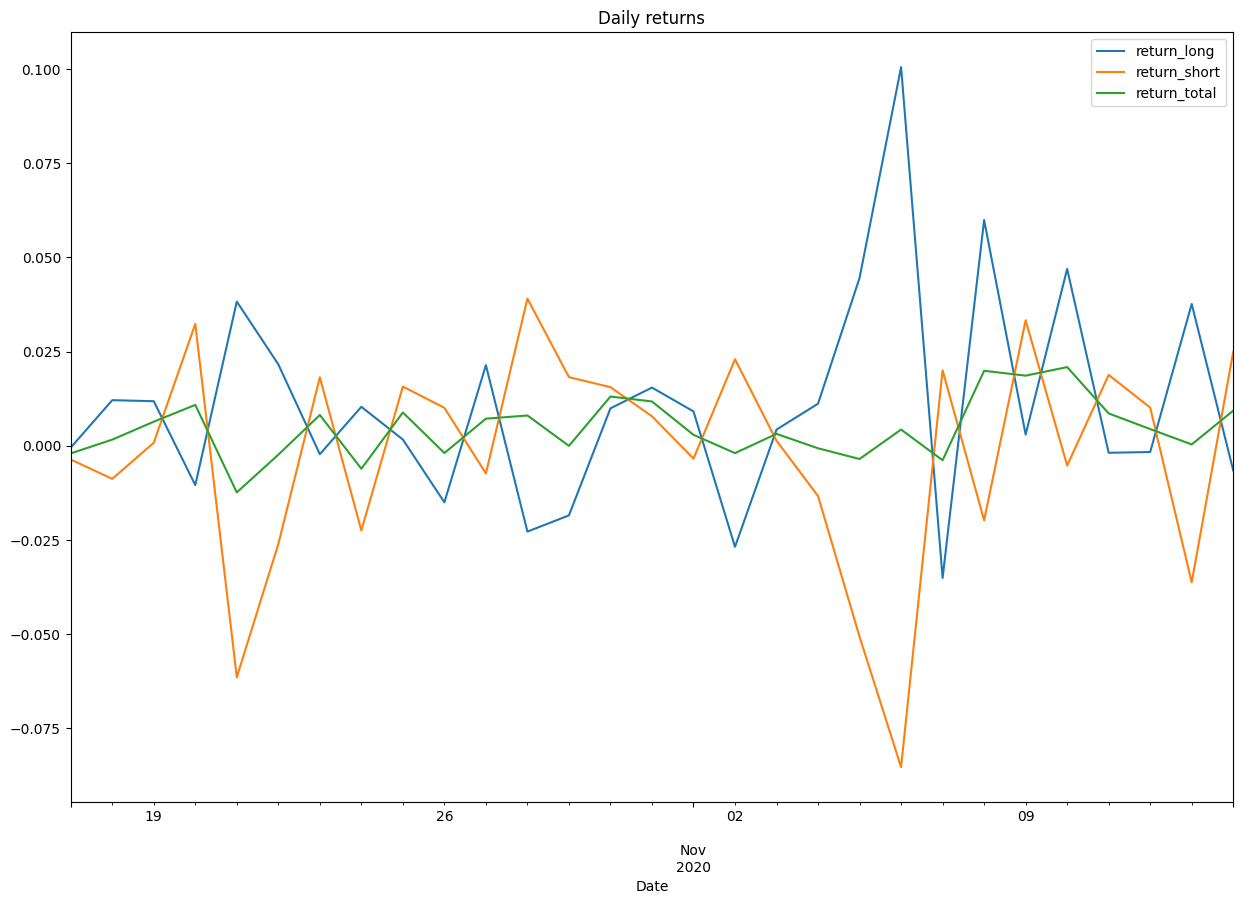

In [12]:
# visualizing the daily returns
daily_rets.plot(figsize=(15, 10), title='Daily returns')

In [13]:
daily_rets_tc

,return_long,return_short,return_total
Date,,,
2020-10-17,-0.009718,-0.010557,-0.010097
2020-10-18,0.001500,-0.015954,-0.007240
2020-10-19,0.001559,-0.008147,-0.003216
2020-10-20,-0.021005,0.022681,0.000726
2020-10-21,0.028978,-0.071329,-0.021990
2020-10-22,0.013204,-0.036936,-0.012027
2020-10-23,-0.012240,0.007803,-0.002014
2020-10-24,-0.000235,-0.031729,-0.016005
2020-10-25,-0.008490,0.006012,-0.001094


<Axes: title={'center': 'Daily returns'}, xlabel='Date'>

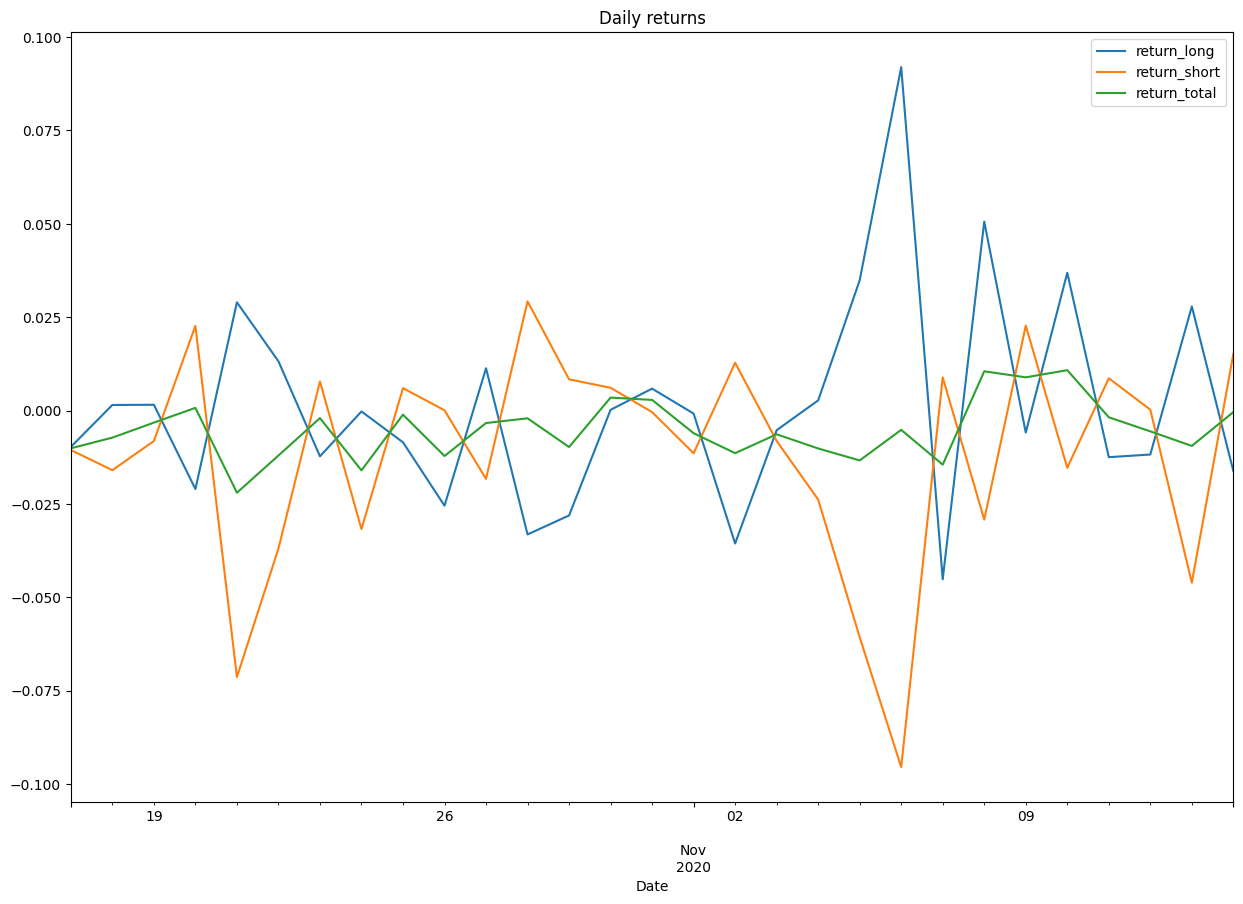

In [14]:
daily_rets_tc.plot(figsize=(15, 10), title='Daily returns')

### 5.2 K-Nearest Neighbors

In [15]:
path_to_data = r'C:\Users\ReinisFals\OneDrive - Peero, SIA\Desktop\Statistical_Arbitrage\binance_stat_arb\3 ML Pairs\predictions\predictions_knn2020.csv'

In [16]:
kpi_df_knn, kpi_trades_df_knn, daily_rets_knn, daily_rets_tc_knn = kpi_backtest(path_to_data, raw_data, model_type='universal', staleness_filter=0.05, model_name="K-Nearest Neighbours", tc=0.001)

[INFO] The KPI for a staleness filter of 0.05 and TC of 0.001 are being caluclated!
K-Nearest Neighbours


c:\Users\ReinisFals\OneDrive - Peero, SIA\Desktop\Statistical_Arbitrage\binance_stat_arb\3 ML Pairs\kpi_backtest.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  kpi_trades_total_helper = kpi_trades_total_helper.sort_index(0, level='Date')


0


In [17]:
kpi_df_knn

,K-Nearest Neighbours,K-Nearest Neighbours_tc
Mean return,0.000883,-0.009559
Standard error,0.000688,0.000684
t-Statistic,1.283344,-13.968512
Minimum,-0.008226,-0.018626
25% Quantile,-0.001437,-0.012053
Median,0.001510,-0.008750
75% Quantile,0.002932,-0.007229
Maximum,0.010936,0.000141
Share > 0,0.655172,0.034483
Standard dev.,0.003641,0.003621


In [18]:
kpi_trades_df_knn

,KPI all trades,KPI long trades,KPI short trades
No. trades,145936.000000,73123.000000,72813.000000
Mean return,-0.000916,-0.000539,-0.001294
Standard error,0.000030,0.000043,0.000042
t-Statistic,-30.510248,-12.539096,-30.909117
Minimum,-0.193115,-0.193115,-0.160356
25% Quantile,-0.005993,-0.005621,-0.006325
Median,-0.001074,-0.000766,-0.001427
75% Quantile,0.004024,0.004349,0.003689
Maximum,0.175755,0.175755,0.129374
Share > 0,0.435211,0.453100,0.417247


In [19]:
daily_rets_knn

,return_long,return_short,return_total
Date,,,
2020-10-17,0.008027,-0.003389,0.002356
2020-10-18,0.009227,-0.014003,-0.002416
2020-10-19,0.001941,0.001219,0.001646
2020-10-20,-0.022707,0.028969,0.002963
2020-10-21,0.043607,-0.058334,-0.008226
2020-10-22,0.022191,-0.025825,-0.001938
2020-10-23,-0.016203,0.007997,-0.003888
2020-10-24,0.005299,-0.016065,-0.005368
2020-10-25,-0.006640,0.009250,0.001436


In [20]:
daily_rets_tc_knn

,return_long,return_short,return_total
Date,,,
2020-10-17,-0.001506,-0.013025,-0.007229
2020-10-18,-0.000799,-0.022850,-0.011847
2020-10-19,-0.008194,-0.008500,-0.008281
2020-10-20,-0.032999,0.018390,-0.007472
2020-10-21,0.032907,-0.068436,-0.018626
2020-10-22,0.011389,-0.036721,-0.012791
2020-10-23,-0.026515,-0.002500,-0.014294
2020-10-24,-0.005504,-0.025769,-0.015617
2020-10-25,-0.016578,-0.000758,-0.008539


### 5.3 Extreme Gradient Boosting

In [21]:
path_to_data = r'C:\Users\ReinisFals\OneDrive - Peero, SIA\Desktop\Statistical_Arbitrage\binance_stat_arb\3 ML Pairs\predictions\predictions_xgb2020.csv'

In [22]:
kpi_df_xgb, kpi_trades_df_xgb, daily_rets_xgb, daily_rets_tc_xgb = kpi_backtest(path_to_data, raw_data, model_type='universal', staleness_filter=0.05, model_name="Extreme Gradient Boosting", tc=0.001)

[INFO] The KPI for a staleness filter of 0.05 and TC of 0.001 are being caluclated!
Extreme Gradient Boosting


c:\Users\ReinisFals\OneDrive - Peero, SIA\Desktop\Statistical_Arbitrage\binance_stat_arb\3 ML Pairs\kpi_backtest.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  kpi_trades_total_helper = kpi_trades_total_helper.sort_index(0, level='Date')


0


In [23]:
kpi_df_xgb

,Extreme Gradient Boosting,Extreme Gradient Boosting_tc
Mean return,0.003432,-0.006561
Standard error,0.001138,0.001102
t-Statistic,3.014428,-5.954741
Minimum,-0.009892,-0.019815
25% Quantile,0.001070,-0.008778
Median,0.002778,-0.007125
75% Quantile,0.005504,-0.004101
Maximum,0.021299,0.010774
Share > 0,0.758621,0.068966
Standard dev.,0.006024,0.005830


In [24]:
kpi_trades_df_xgb

,KPI all trades,KPI long trades,KPI short trades
No. trades,139295.000000,69915.000000,69380.000000
Mean return,-0.000655,-0.000155,-0.001159
Standard error,0.000037,0.000051,0.000053
t-Statistic,-17.836653,-3.024117,-22.030227
Minimum,-0.177755,-0.138569,-0.177755
25% Quantile,-0.006301,-0.005790,-0.006733
Median,-0.000950,-0.000635,-0.001265
75% Quantile,0.004551,0.004772,0.004310
Maximum,0.218452,0.140193,0.218452
Share > 0,0.447532,0.462047,0.432906


In [48]:
daily_rets_xgb

,return_long,return_short,return_total
Date,,,
2020-10-17,0.003306,-0.004058,-0.000349
2020-10-18,0.011788,-0.007164,0.002292
2020-10-19,0.002981,0.001858,0.002475
2020-10-20,-0.018905,0.019840,0.000391
2020-10-21,0.035799,-0.051465,-0.008445
2020-10-22,0.021508,-0.028856,-0.003855
2020-10-23,-0.007555,0.010760,0.001783
2020-10-24,0.006278,-0.013331,-0.003521
2020-10-25,-0.010039,0.008628,-0.000632


In [49]:
daily_rets_tc_xgb

,return_long,return_short,return_total
Date,,,
2020-10-17,-0.012933,-0.019606,-0.016241
2020-10-18,-0.006886,-0.020029,-0.013457
2020-10-19,-0.013636,-0.014642,-0.014083
2020-10-20,-0.037029,0.002816,-0.017198
2020-10-21,0.018935,-0.069466,-0.025920
2020-10-22,0.005574,-0.048653,-0.021772
2020-10-23,-0.025191,-0.007088,-0.015958
2020-10-24,-0.012032,-0.029129,-0.020564
2020-10-25,-0.026594,-0.007606,-0.017030
